# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

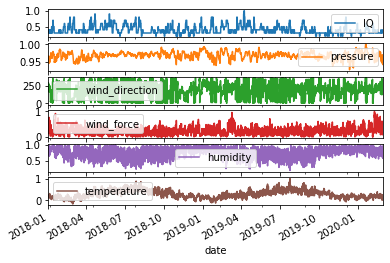

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.4,0.953970,0.652632,0.73,0.190821,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 03:00:00+00:00,0.4,0.956463,0.426316,0.84,0.149758,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 06:00:00+00:00,0.4,0.957518,0.394737,0.82,0.142512,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 09:00:00+00:00,0.4,0.956367,0.321053,0.84,0.135266,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 12:00:00+00:00,0.4,0.951669,0.357895,0.87,0.164251,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
features = pd.concat([features, pd.get_dummies(features['wind_direction'])], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 16 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (784, 16, 42)
y_train : (784, 3, 1)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input

In [9]:
OPTIMIZER = RMSprop(0.0005)

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = LSTM(512,input_shape=input_shape,name='LSTM_layer')(inp)
    _ = Dense(128,name="Intermediate_dense_layer")(_)
    
    outD1 = Dense(1,name="D1")(_)
    outD2 = Dense(1,name="D2")(_)
    outD3 = Dense(1,name="D3")(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])
    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'mse', 'D2': 'mse', 'D3': 'mse'}, metrics={'D1': 'mae', 'D2': 'mae', 'D3': 'mae'})
    model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 42)       0                                            
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 512)          1136640     input_1[0][0]                    
__________________________________________________________________________________________________
Intermediate_dense_layer (Dense (None, 128)          65664       LSTM_layer[0][0]                 
__________________________________________________________________________________________________
D1 (Dense)                      (None, 1)            129         Intermediate_dense_layer[0][0]   
__________________________________________________________________________________________________
D2 (De

### Train

In [10]:
EPOCHS = 40
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 627 samples, validate on 157 samples


Epoch 1/40
627/627 [==============================] - 3s 5ms/step - loss: 0.1359 - D1_loss: 0.0282 - D2_loss: 0.0545 - D3_loss: 0.0532 - D1_mean_absolute_error: 0.1239 - D2_mean_absolute_error: 0.1523 - D3_mean_absolute_error: 0.1552 - val_loss: 0.0799 - val_D1_loss: 0.0259 - val_D2_loss: 0.0257 - val_D3_loss: 0.0284 - val_D1_mean_absolute_error: 0.1164 - val_D2_mean_absolute_error: 0.1157 - val_D3_mean_absolute_error: 0.1240
Epoch 2/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0558 - D1_loss: 0.0185 - D2_loss: 0.0167 - D3_loss: 0.0205 - D1_mean_absolute_error: 0.1032 - D2_mean_absolute_error: 0.0974 - D3_mean_absolute_error: 0.1112 - val_loss: 0.0852 - val_D1_loss: 0.0392 - val_D2_loss: 0.0249 - val_D3_loss: 0.0211 - val_D1_mean_absolute_error: 0.1540 - val_D2_mean_absolute_error: 0.1158 - val_D3_mean_absolute_error: 0.1

627/627 [==============================] - 2s 3ms/step - loss: 0.0244 - D1_loss: 0.0068 - D2_loss: 0.0078 - D3_loss: 0.0098 - D1_mean_absolute_error: 0.0633 - D2_mean_absolute_error: 0.0667 - D3_mean_absolute_error: 0.0756 - val_loss: 0.0751 - val_D1_loss: 0.0203 - val_D2_loss: 0.0275 - val_D3_loss: 0.0274 - val_D1_mean_absolute_error: 0.1053 - val_D2_mean_absolute_error: 0.1196 - val_D3_mean_absolute_error: 0.1278
Epoch 37/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0235 - D1_loss: 0.0059 - D2_loss: 0.0074 - D3_loss: 0.0101 - D1_mean_absolute_error: 0.0590 - D2_mean_absolute_error: 0.0655 - D3_mean_absolute_error: 0.0744 - val_loss: 0.0793 - val_D1_loss: 0.0203 - val_D2_loss: 0.0289 - val_D3_loss: 0.0301 - val_D1_mean_absolute_error: 0.1065 - val_D2_mean_absolute_error: 0.1253 - val_D3_mean_absolute_error: 0.1331
Epoch 38/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0214 - D1_loss: 0.0057 - D2_loss: 0.0070 - D3_loss: 0.0087 - D1_mean_abso

Epoch 15/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0192 - D1_loss: 0.0060 - D2_loss: 0.0059 - D3_loss: 0.0073 - D1_mean_absolute_error: 0.0600 - D2_mean_absolute_error: 0.0596 - D3_mean_absolute_error: 0.0649 - val_loss: 0.0418 - val_D1_loss: 0.0111 - val_D2_loss: 0.0128 - val_D3_loss: 0.0179 - val_D1_mean_absolute_error: 0.0775 - val_D2_mean_absolute_error: 0.0882 - val_D3_mean_absolute_error: 0.1077
Epoch 16/40
627/627 [==============================] - 3s 5ms/step - loss: 0.0191 - D1_loss: 0.0064 - D2_loss: 0.0059 - D3_loss: 0.0068 - D1_mean_absolute_error: 0.0614 - D2_mean_absolute_error: 0.0586 - D3_mean_absolute_error: 0.0636 - val_loss: 0.0369 - val_D1_loss: 0.0082 - val_D2_loss: 0.0121 - val_D3_loss: 0.0166 - val_D1_mean_absolute_error: 0.0737 - val_D2_mean_absolute_error: 0.0878 - val_D3_mean_absolute_error: 0.0985
Epoch 17/40
627/627 [==============================] - 4s 6ms/step - loss: 0.0183 - D1_loss: 0.0052 - D2_loss: 0.0056 - D3_loss: 0.0074 - 

627/627 [==============================] - 2s 3ms/step - loss: 0.0096 - D1_loss: 0.0037 - D2_loss: 0.0025 - D3_loss: 0.0035 - D1_mean_absolute_error: 0.0470 - D2_mean_absolute_error: 0.0389 - D3_mean_absolute_error: 0.0458 - val_loss: 0.0422 - val_D1_loss: 0.0090 - val_D2_loss: 0.0135 - val_D3_loss: 0.0197 - val_D1_mean_absolute_error: 0.0747 - val_D2_mean_absolute_error: 0.0902 - val_D3_mean_absolute_error: 0.1152
Epoch 35/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0095 - D1_loss: 0.0031 - D2_loss: 0.0031 - D3_loss: 0.0034 - D1_mean_absolute_error: 0.0426 - D2_mean_absolute_error: 0.0429 - D3_mean_absolute_error: 0.0455 - val_loss: 0.0547 - val_D1_loss: 0.0119 - val_D2_loss: 0.0200 - val_D3_loss: 0.0229 - val_D1_mean_absolute_error: 0.0867 - val_D2_mean_absolute_error: 0.1091 - val_D3_mean_absolute_error: 0.1224
Epoch 36/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0089 - D1_loss: 0.0031 - D2_loss: 0.0026 - D3_loss: 0.0032 - D1_mean_abso

Epoch 13/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0076 - D1_loss: 0.0024 - D2_loss: 0.0025 - D3_loss: 0.0027 - D1_mean_absolute_error: 0.0375 - D2_mean_absolute_error: 0.0400 - D3_mean_absolute_error: 0.0401 - val_loss: 0.0194 - val_D1_loss: 0.0044 - val_D2_loss: 0.0064 - val_D3_loss: 0.0086 - val_D1_mean_absolute_error: 0.0516 - val_D2_mean_absolute_error: 0.0608 - val_D3_mean_absolute_error: 0.0730
Epoch 14/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0072 - D1_loss: 0.0025 - D2_loss: 0.0021 - D3_loss: 0.0026 - D1_mean_absolute_error: 0.0392 - D2_mean_absolute_error: 0.0356 - D3_mean_absolute_error: 0.0392 - val_loss: 0.0149 - val_D1_loss: 0.0045 - val_D2_loss: 0.0049 - val_D3_loss: 0.0055 - val_D1_mean_absolute_error: 0.0525 - val_D2_mean_absolute_error: 0.0536 - val_D3_mean_absolute_error: 0.0591
Epoch 15/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0066 - D1_loss: 0.0024 - D2_loss: 0.0021 - D3_loss: 0.0021 - 

627/627 [==============================] - 2s 3ms/step - loss: 0.0043 - D1_loss: 0.0015 - D2_loss: 0.0013 - D3_loss: 0.0015 - D1_mean_absolute_error: 0.0304 - D2_mean_absolute_error: 0.0279 - D3_mean_absolute_error: 0.0301 - val_loss: 0.0187 - val_D1_loss: 0.0053 - val_D2_loss: 0.0057 - val_D3_loss: 0.0076 - val_D1_mean_absolute_error: 0.0569 - val_D2_mean_absolute_error: 0.0593 - val_D3_mean_absolute_error: 0.0669
Epoch 33/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0044 - D1_loss: 0.0017 - D2_loss: 0.0014 - D3_loss: 0.0013 - D1_mean_absolute_error: 0.0323 - D2_mean_absolute_error: 0.0291 - D3_mean_absolute_error: 0.0288 - val_loss: 0.0230 - val_D1_loss: 0.0065 - val_D2_loss: 0.0072 - val_D3_loss: 0.0093 - val_D1_mean_absolute_error: 0.0655 - val_D2_mean_absolute_error: 0.0644 - val_D3_mean_absolute_error: 0.0774
Epoch 34/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0040 - D1_loss: 0.0013 - D2_loss: 0.0014 - D3_loss: 0.0014 - D1_mean_abso

Epoch 11/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0040 - D1_loss: 0.0013 - D2_loss: 0.0012 - D3_loss: 0.0015 - D1_mean_absolute_error: 0.0276 - D2_mean_absolute_error: 0.0268 - D3_mean_absolute_error: 0.0297 - val_loss: 0.0053 - val_D1_loss: 0.0016 - val_D2_loss: 0.0016 - val_D3_loss: 0.0021 - val_D1_mean_absolute_error: 0.0305 - val_D2_mean_absolute_error: 0.0309 - val_D3_mean_absolute_error: 0.0358
Epoch 12/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0039 - D1_loss: 0.0013 - D2_loss: 0.0013 - D3_loss: 0.0013 - D1_mean_absolute_error: 0.0286 - D2_mean_absolute_error: 0.0283 - D3_mean_absolute_error: 0.0287 - val_loss: 0.0053 - val_D1_loss: 0.0018 - val_D2_loss: 0.0016 - val_D3_loss: 0.0018 - val_D1_mean_absolute_error: 0.0348 - val_D2_mean_absolute_error: 0.0326 - val_D3_mean_absolute_error: 0.0344
Epoch 13/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0040 - D1_loss: 0.0017 - D2_loss: 0.0011 - D3_loss: 0.0013 - 

Epoch 30/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0029 - D1_loss: 0.0011 - D2_loss: 7.0131e-04 - D3_loss: 0.0010 - D1_mean_absolute_error: 0.0258 - D2_mean_absolute_error: 0.0208 - D3_mean_absolute_error: 0.0254 - val_loss: 0.0071 - val_D1_loss: 0.0019 - val_D2_loss: 0.0022 - val_D3_loss: 0.0030 - val_D1_mean_absolute_error: 0.0344 - val_D2_mean_absolute_error: 0.0369 - val_D3_mean_absolute_error: 0.0455
Epoch 31/40
627/627 [==============================] - 2s 4ms/step - loss: 0.0031 - D1_loss: 0.0013 - D2_loss: 7.4331e-04 - D3_loss: 9.9407e-04 - D1_mean_absolute_error: 0.0277 - D2_mean_absolute_error: 0.0212 - D3_mean_absolute_error: 0.0240 - val_loss: 0.0058 - val_D1_loss: 0.0016 - val_D2_loss: 0.0020 - val_D3_loss: 0.0022 - val_D1_mean_absolute_error: 0.0306 - val_D2_mean_absolute_error: 0.0351 - val_D3_mean_absolute_error: 0.0374
Epoch 32/40
627/627 [==============================] - 2s 3ms/step - loss: 0.0028 - D1_loss: 0.0011 - D2_loss: 7.2815e-04 - D3

628/628 [==============================] - 2s 3ms/step - loss: 0.0023 - D1_loss: 7.6292e-04 - D2_loss: 7.1088e-04 - D3_loss: 8.0978e-04 - D1_mean_absolute_error: 0.0220 - D2_mean_absolute_error: 0.0203 - D3_mean_absolute_error: 0.0219 - val_loss: 0.0033 - val_D1_loss: 7.7135e-04 - val_D2_loss: 0.0012 - val_D3_loss: 0.0014 - val_D1_mean_absolute_error: 0.0222 - val_D2_mean_absolute_error: 0.0277 - val_D3_mean_absolute_error: 0.0282
Epoch 27/40
628/628 [==============================] - 2s 4ms/step - loss: 0.0026 - D1_loss: 7.9840e-04 - D2_loss: 9.0554e-04 - D3_loss: 9.3938e-04 - D1_mean_absolute_error: 0.0214 - D2_mean_absolute_error: 0.0233 - D3_mean_absolute_error: 0.0219 - val_loss: 0.0032 - val_D1_loss: 7.6817e-04 - val_D2_loss: 9.5666e-04 - val_D3_loss: 0.0015 - val_D1_mean_absolute_error: 0.0222 - val_D2_mean_absolute_error: 0.0249 - val_D3_mean_absolute_error: 0.0301
Epoch 28/40
628/628 [==============================] - 2s 4ms/step - loss: 0.0023 - D1_loss: 5.7235e-04 - D2_loss:

________________

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [12]:
y_pred = model.predict(x_train)

y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

Show the results in graphs:

Prediction of the air index quality (on training data)


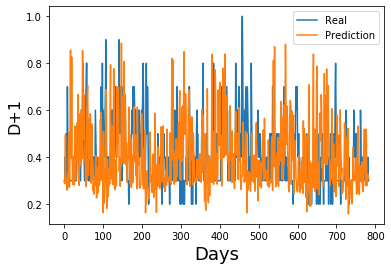

val_D1_loss 0.00105
val_D1_mean_absolute_error 0.02634
D1_loss 0.00082
D1_mean_absolute_error 0.02129


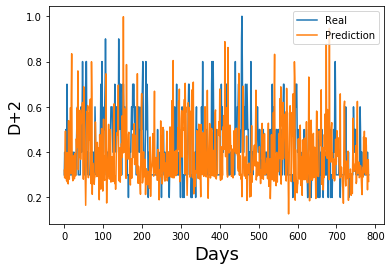

val_D2_loss 0.00105
val_D2_mean_absolute_error 0.02595
D2_loss 0.00056
D2_mean_absolute_error 0.01831


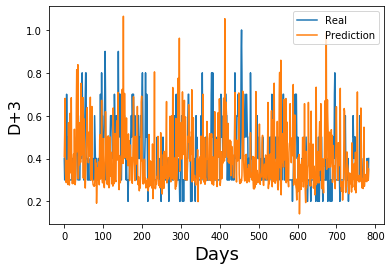

val_D3_loss 0.0014
val_D3_mean_absolute_error 0.02817
D3_loss 0.00064
D3_mean_absolute_error 0.0199


In [17]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))